In [1]:
import os
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from zipfile import ZipFile


!pip install kaggle


os.environ['KAGGLE_USERNAME'] = "cruk12"
os.environ['KAGGLE_KEY'] = "f6ac77148464b981fcc85de69da4347e"


!kaggle datasets download -d jessicali9530/lfw-dataset


with ZipFile('lfw-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lfw-dataset')


os.remove('lfw-dataset.zip')


 94% 106M/112M [00:01<00:00, 90.9MB/s]
100% 112M/112M [00:01<00:00, 78.6MB/s]


In [3]:

def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    features = features.squeeze(0)
    return features


def compute_hog(img):
    resized_img = resize(img, (128*4, 64*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd


def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))
    val_ar.append(get_pixel(img, center, x, y+1))
    val_ar.append(get_pixel(img, center, x+1, y+1))
    val_ar.append(get_pixel(img, center, x+1, y))
    val_ar.append(get_pixel(img, center, x+1, y-1))
    val_ar.append(get_pixel(img, center, x, y-1))
    val_ar.append(get_pixel(img, center, x-1, y-1))
    val_ar.append(get_pixel(img, center, x-1, y))

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp.flatten()


In [4]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.4MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
lfw_folder = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                # hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                cnn_feature = cnn_feature.flatten()
                # combined_feature = np.concatenate((hog_feature, lbp_feature, cnn_feature))

                X.append(cnn_feature)
                y.append(folder_name)


In [6]:
np.array(X).shape

(1288, 2048)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Create logistic regression model
logistic_model = LogisticRegression(max_iter=1000, multi_class='ovr')  # Increase max_iter to ensure convergence

# Fit the model
logistic_model.fit(X_train, y_train_encoded)

# Predict on test data
y_pred_log_reg = logistic_model.predict(X_test)

# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test_encoded, y_pred_log_reg)
print("Accuracy on test data:", accuracy_log_reg)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg, target_names=label_encoder.classes_))

Accuracy on test data: 0.8294573643410853
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.93      0.93      0.93        14
     Colin_Powell       0.82      0.93      0.87        40
  Donald_Rumsfeld       0.93      0.79      0.86        34
    George_W_Bush       0.84      0.90      0.87       109
Gerhard_Schroeder       0.74      0.61      0.67        23
      Hugo_Chavez       0.44      0.36      0.40        11
       Tony_Blair       0.81      0.78      0.79        27

         accuracy                           0.83       258
        macro avg       0.79      0.76      0.77       258
     weighted avg       0.83      0.83      0.83       258



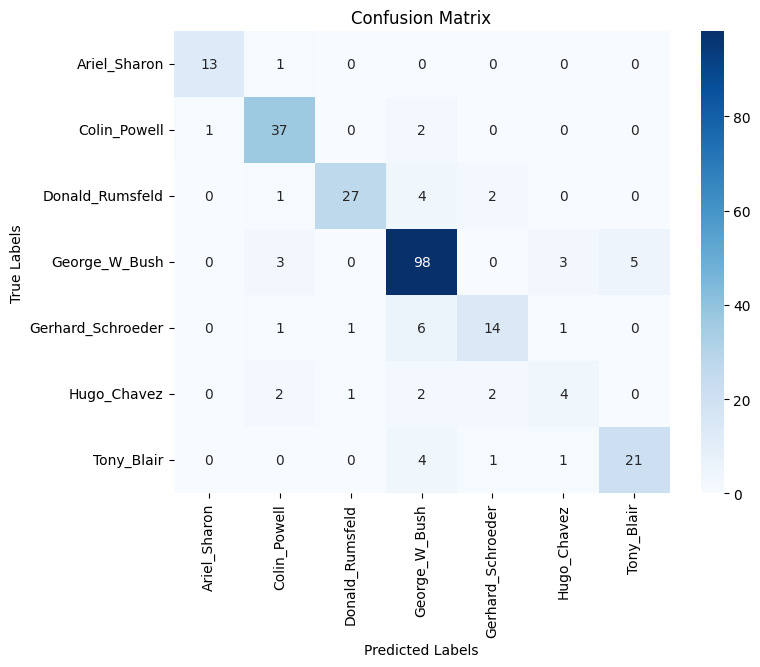

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_log_reg)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
y_pred_log_reg = logistic_model.predict(X_train)
accuracy_log_reg = accuracy_score(y_train_encoded, y_pred_log_reg)
print("Logistic Regression")
print("Accuracy on train set:", accuracy_log_reg)

Logistic Regression
Accuracy on train set: 1.0


Using Grid Search to find best parameters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [ 0.1, 1, 10],
    'max_iter': [100, 300, 500]
}

# Create logistic regression model
logistic_model = LogisticRegression(multi_class='ovr')

# Create GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train_encoded)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred_log_reg = best_model.predict(X_test)

# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test_encoded, y_pred_log_reg)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Accuracy on test data:", accuracy_log_reg)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg, target_names=label_encoder.classes_))


Best parameters found by GridSearchCV: {'C': 10, 'max_iter': 300, 'penalty': 'l2'}
Accuracy on test data: 0.8488372093023255
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.93      0.93      0.93        14
     Colin_Powell       0.84      0.90      0.87        40
  Donald_Rumsfeld       0.93      0.82      0.87        34
    George_W_Bush       0.87      0.92      0.89       109
Gerhard_Schroeder       0.75      0.65      0.70        23
      Hugo_Chavez       0.44      0.36      0.40        11
       Tony_Blair       0.85      0.85      0.85        27

         accuracy                           0.85       258
        macro avg       0.80      0.78      0.79       258
     weighted avg       0.85      0.85      0.85       258



In [ ]:
# Create logistic regression model
logistic_model = LogisticRegression(C = 10, max_iter=300, penalty = 'l2', multi_class='ovr')  # Increase max_iter to ensure convergence

# Fit the model
logistic_model.fit(X_train, y_train_encoded)

# Predict on test data
y_pred_log_reg = logistic_model.predict(X_test)

# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test_encoded, y_pred_log_reg)
print("Accuracy on test data:", accuracy_log_reg)

Accuracy on test data: 0.8488372093023255


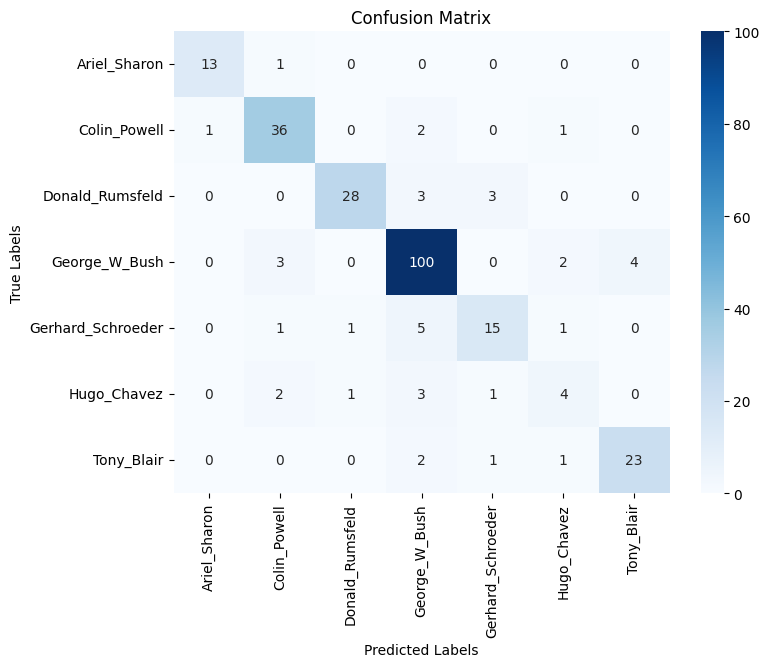

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_log_reg)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Training Accuracy on some hyperparameter

In [ ]:
# Use the best hyperparameters obtained from grid search
best_params = {'C': 10, 'max_iter': 300, 'penalty': 'l2'}

# Create logistic regression model with best hyperparameters
best_logistic_model = LogisticRegression(**best_params, multi_class='ovr')

# Fit the model on training data
best_logistic_model.fit(X_train, y_train_encoded)

# Predict on training data
y_pred_train = best_logistic_model.predict(X_train)

# Calculate training accuracy
accuracy_train = accuracy_score(y_train_encoded, y_pred_train)

print("Training Accuracy with best hyperparameters:", accuracy_train)

Training Accuracy with best hyperparameters: 1.0


PCA on logistic regression

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

logistic_model.fit(X_train_pca, y_train_encoded)
y_pred_log_reg = logistic_model.predict(X_test_pca)
accuracy = accuracy_score(y_test_encoded, y_pred_log_reg)
print("PCA + Logistic Regression Classifier")
print("Accuracy on test set:", accuracy)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg, target_names=label_encoder.classes_))

PCA + Logistic Regression Classifier
Accuracy on test set: 0.4069767441860465
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        14
     Colin_Powell       0.29      0.28      0.28        40
  Donald_Rumsfeld       0.00      0.00      0.00        34
    George_W_Bush       0.43      0.86      0.57       109
Gerhard_Schroeder       0.00      0.00      0.00        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.00      0.00      0.00        27

         accuracy                           0.41       258
        macro avg       0.10      0.16      0.12       258
     weighted avg       0.23      0.41      0.29       258



In [ ]:
y_pred_log_reg = logistic_model.predict(X_train_pca)
accuracy_log_reg = accuracy_score(y_train_encoded, y_pred_log_reg)
print("PCA + Logistic Regression Classifier")
print("Accuracy on train set:", accuracy_log_reg)

PCA + Logistic Regression Classifier
Accuracy on train set: 0.429126213592233


LDA on logistic regression

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)
X_train_lda = lda.fit_transform(X_train, y_train_encoded)
X_test_lda = lda.transform(X_test)
logistic_model.fit(X_train_lda, y_train_encoded)
y_pred_log_reg = logistic_model.predict(X_test_lda)
accuracy_gnb = accuracy_score(y_test_encoded, y_pred_log_reg)
print("LDA + Logistic Regression")
print("Accuracy on Test set after LDA:", accuracy_gnb)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg, target_names=label_encoder.classes_))

LDA + Logistic Regression
Accuracy on Test set after LDA: 0.7945736434108527
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.85      0.79      0.81        14
     Colin_Powell       0.86      0.78      0.82        40
  Donald_Rumsfeld       0.76      0.76      0.76        34
    George_W_Bush       0.86      0.90      0.88       109
Gerhard_Schroeder       0.47      0.65      0.55        23
      Hugo_Chavez       0.60      0.27      0.37        11
       Tony_Blair       0.88      0.78      0.82        27

         accuracy                           0.79       258
        macro avg       0.75      0.70      0.72       258
     weighted avg       0.80      0.79      0.79       258



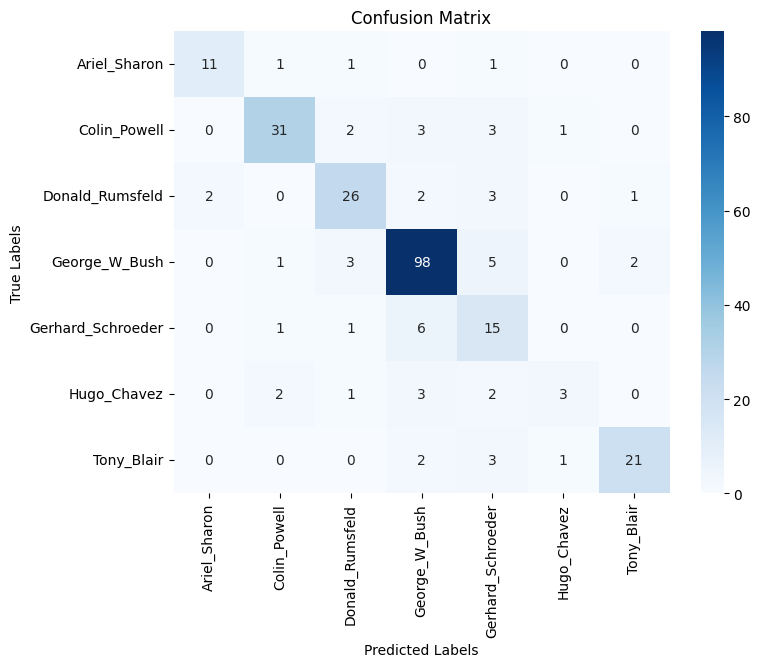

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_log_reg)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
y_pred_log_reg = logistic_model.predict(X_train_lda)
accuracy_log_reg = accuracy_score(y_train_encoded, y_pred_log_reg)
print("LDA + Logistic Regression")
print("Accuracy on Train set:", accuracy_log_reg)

LDA + Logistic Regression
Accuracy on Train set: 0.9990291262135922


Using Grid Search to find best parameters

In [ ]:
# Create logistic regression model
logistic_model = LogisticRegression(multi_class='ovr')

# Define hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.1, 1, 10],
    'max_iter': [100, 300, 500]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the data
grid_search.fit(X_train_lda, y_train_encoded)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict with the best model on test data
y_pred_log_reg = best_model.predict(X_test_lda)

# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test_encoded, y_pred_log_reg)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Accuracy on test data after LDA:", accuracy_log_reg)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg, target_names=label_encoder.classes_))


Best parameters found by GridSearchCV: {'C': 0.1, 'max_iter': 100, 'penalty': 'none'}
Accuracy on test data after LDA: 0.7635658914728682
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.75      0.64      0.69        14
     Colin_Powell       0.76      0.80      0.78        40
  Donald_Rumsfeld       0.74      0.68      0.71        34
    George_W_Bush       0.87      0.82      0.84       109
Gerhard_Schroeder       0.46      0.78      0.58        23
      Hugo_Chavez       0.80      0.36      0.50        11
       Tony_Blair       0.81      0.81      0.81        27

         accuracy                           0.76       258
        macro avg       0.74      0.70      0.70       258
     weighted avg       0.79      0.76      0.77       258



In [ ]:
# Create logistic regression model
logistic_model = LogisticRegression(C = 0.1, max_iter=100, penalty = 'none', multi_class='ovr')  # Increase max_iter to ensure convergence

# Fit the model
logistic_model.fit(X_train, y_train_encoded)

# Predict on test data
y_pred_log_reg = logistic_model.predict(X_test)

# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test_encoded, y_pred_log_reg)
print("Accuracy on test data:", accuracy_log_reg)

Accuracy on test data: 0.7674418604651163


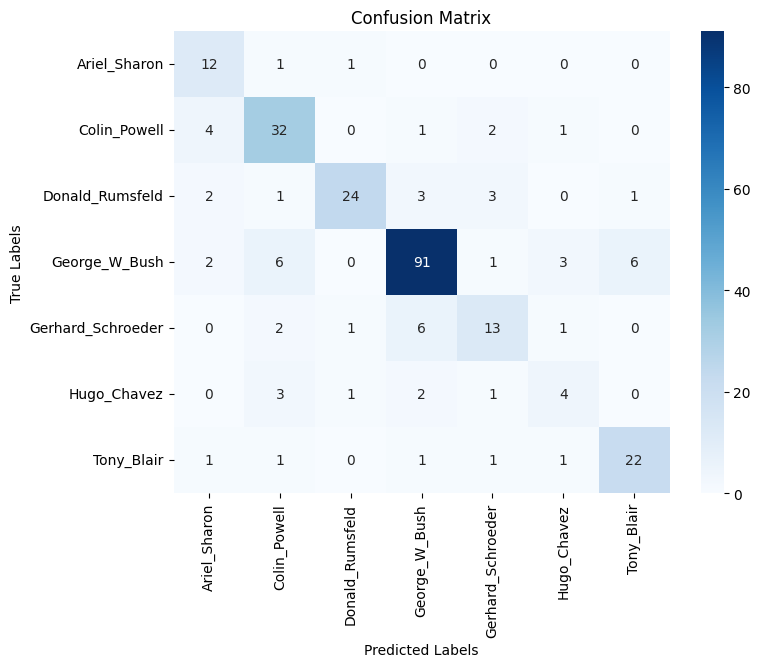

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_log_reg)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Training Accuracy on some hyperparameter

In [ ]:
# Use the best hyperparameters obtained from grid search
best_params = {'C': 0.1, 'max_iter': 100, 'penalty': 'none'}

# Create logistic regression model with best hyperparameters
best_logistic_model = LogisticRegression(**best_params, multi_class='ovr')

# Fit the model on training data
best_logistic_model.fit(X_train_lda, y_train_encoded)

# Predict on training data
y_pred_train = best_logistic_model.predict(X_train_lda)

# Calculate training accuracy
accuracy_train = accuracy_score(y_train_encoded, y_pred_train)

print("Training Accuracy with best hyperparameters:", accuracy_train)

Training Accuracy with best hyperparameters: 1.0
